<a href="https://colab.research.google.com/github/oscarserc/TESIS_Transformers/blob/main/3a_Practica_Visual_TRANSFORMERS_ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 526 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 829 kB 40.9 MB/s 
     |████████████████████████████████| 132 kB 56.7 MB/s 
     |████████████████████████████████| 332 kB 53.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.0 MB/s 
     |████████████████████████████████| 160 kB 39.9 MB/s 
     |████████████████████████████████| 192 kB 53.9 MB/s 
     |████████████████████████████████| 271 kB 37.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d2e2eaf2391ad1c83ca29ab52cf47b2c71d2673812139514b512ae4d68b8107f
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:

import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X.iloc[ix]).float().view(1, 28, 28), torch.tensor(self.y.iloc[ix]).long()


class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, batch_size: int=64):
    super().__init__()
    self.batch_size = batch_size 

  def setup(self, stage=None):
    mnist = fetch_openml('mnist_784', version=1)
    X, y  = mnist['data'], mnist['target']
    X_train, X_test = X[:60000]/255., X[60000:]/255.
    y_train, y_test = y[:60000].astype(int), y[60000:].astype(int)
    self.train_ds = Dataset(X_train, y_train)
    self.val_ds   = Dataset(X_test, y_test)

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size)             


In [ ]:

dm_mnist = MNISTDataModule()
dm_mnist.setup()

imgs, labels = next(iter(dm_mnist.train_dataloader()))
imgs.shape, labels.shape


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

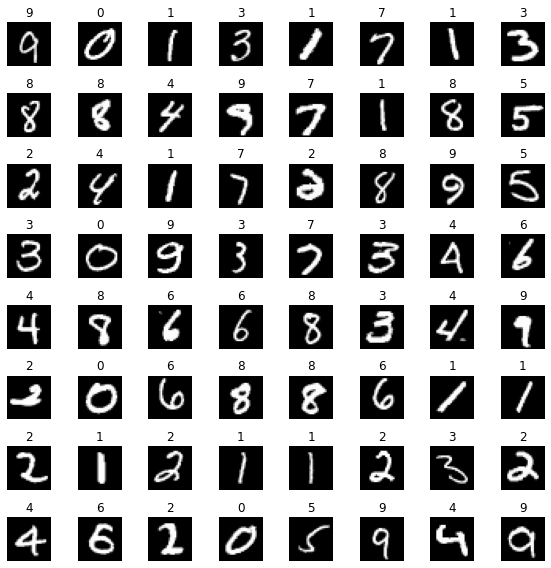

In [ ]:

r, c = 8, 8
fig = plt.figure(figsize=(r,c))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.set_title(label.item())
plt.tight_layout()
plt.show()    


# **MÓDULOS DEL TRANSFORMER**

In [ ]:

# ---------------
#  EMBEDDING
# ---------------

import torch.nn as nn

class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_chans, embed_dim):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size // patch_size)**2
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.proj(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x


In [ ]:

pe = PatchEmbedding(28, 7, 1, 100)
 
salidas = pe(imgs)
salidas.shape 


torch.Size([64, 16, 100])

In [ ]:

# ----------------------
#  MULTI-HEAD ATTENTION
# ----------------------

import math

class MultiHeadAttention(nn.Module):
  def __init__(self, n_embd, n_heads):
    super().__init__()
    self.n_heads = n_heads

    # KEY, QUERY, VALUE projections
    self.key = nn.Linear(n_embd, n_embd*n_heads)
    self.query = nn.Linear(n_embd, n_embd*n_heads)
    self.value = nn.Linear(n_embd, n_embd*n_heads)

    # PROYECCIÓN DE SALIDA
    self.proj = nn.Linear(n_embd*n_heads, n_embd)

  def forward(self, x):
    B, L, F = x.size()

    # CALCULAMOS LOS VALORES DE: KEY, QUERY y VALUES para todas las 'HEADS'
    # Trasladamos 'n_heads' para ser la dimensión del BATCH
    k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3)      # (B, nh, L, F)
    q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3)    #    "     "
    v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3)    #    "     "

    # ATTENTION
    att = (q @ k.transpose(-2, -1))*(1.0 / math.sqrt(k.size(-1)))
    att = torch.nn.functional.softmax(att, dim=-1)
    y = att @ v
    y = y.transpose(1,2).contiguous().view(B, L, F*self.n_heads)

    return self.proj(y)


In [ ]:

# ---------------------
#  BLOQUE TRANSFORMER
# ---------------------

class TransformerBlock(nn.Module):
  def __init__(self, n_embd, n_heads):
    super().__init__()
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)
    self.attn = MultiHeadAttention(n_embd, n_heads)
    self.mlp = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4*n_embd, n_embd)
    )

  def forward(self, x):
    x = x + self.attn(self.ln1(x))
    x = x + self.mlp(self.ln2(x))
    return x  


In [ ]:

class ViT(nn.Module):
  def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=100, n_heads=3, n_layers=3, n_classes=10):
    super().__init__()

    self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))

    self.transformer = torch.nn.Sequential(*[TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)])

    self.ln = nn.LayerNorm(embed_dim)
    self.fc = torch.nn.Linear(embed_dim, n_classes)

  def forward(self, x):
    e = self.patch_embed(x)
    B, L, E = e.size()

    cls_token = self.cls_token.expand(B, -1, -1)
    e = torch.cat((cls_token, e), dim=1)
    e = e + self.pos_embed

    z = self.transformer(e)

    cls_token_final = z[:,0]
    y = self.fc(cls_token_final)

    return y  


In [ ]:
modelo_vit = ViT()

salidas_vit =  modelo_vit(imgs)
salidas_vit.shape

torch.Size([64, 10])

In [ ]:

# =============
#    MODELO
# =============

class Model(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.vit = ViT()

  def forward(self, x):
    return self.vit(x)

  def predict(self, x):
    with torch.no_grad():
      y_hat = self(x)
      return torch.argmax(y_hat, axis=1)

  def compute_loss_and_acc(self, batch):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    acc  = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('loss', loss)
    self.log('acc', acc, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('val_loss', loss, prog_bar=True)
    self.log('val_acc', acc, prog_bar=True)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
    return optimizer          


In [ ]:

modelo = Model()

salida = modelo(imgs)
salida.shape




torch.Size([64, 10])

In [ ]:

modelo = Model()
trainer = pl.Trainer(max_epochs=2, gpus=0, logger=None)
trainer.fit(modelo, dm_mnist)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type | Params
------------------------------
0 | vit  | ViT  | 613 K 
------------------------------
613 K     Trainable params
0         Non-trainable params
613 K     Total params
2.455     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:

imgs, labels = next(iter(dm_mnist.val_dataloader()))
predicciones = modelo.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(r,c))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(f'{label.item()}/{predicciones[ix].item()}', color='green' if label == predicciones[ix].item() else 'red')
plt.tight_layout()
plt.show()    


# **MODELO DE UNA LIBRERÍA YA IMPLEMENTADO**: librería timm